## PyTorch autograd examples

In this example, we calculate transfer maps using PyTorch autograd Jacobian and compare times against numerical differentiation. We also calculate the gradient and the Hessian of the beamsize of a 10 quadrupole lattice with respect to the quadrupole strengths. 

In [1]:
import torch
import numpy as np

from bmadx import Particle, Drift, Quadrupole
from bmadx import track_element, track_lattice
from bmadx import M_ELECTRON


import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # for high DPI displays in MacOS

torch.set_printoptions(precision= 8, sci_mode=True)

/home/jp/mambaforge/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create torch particle beam
s = 0.0 # initial s
p0c = 4e7 # reference momentum in eV

# Initial beam distribution
n_particles = 10_000 # number of particles in beam
coords = np.random.multivariate_normal(mean = np.zeros(6),
                                       cov = 1e-6*np.identity(6),
                                       size = n_particles
                                      )
beam_np = Particle(*coords.T, s=s, p0c=p0c, mc2=M_ELECTRON)

beam_torch = Particle(*torch.tensor(coords.T),
                      s=torch.tensor(s),
                      p0c=torch.tensor(p0c),
                      mc2=torch.tensor(M_ELECTRON))

In [3]:
# Tracking though element takes incoming particle coordinate
# type (i.e., torch tensor in this case) for the tracking regarldless
# the element parameter types.
q = Quadrupole(L=0.1, K1=10.0)
track_element(beam_torch, q)

Particle(x=tensor([ 1.28367426e-05, -1.44892418e-03,  5.90247140e-04,  ...,
        -1.70574617e-03,  1.93567941e-04,  2.31237214e-04],
       dtype=torch.float64), px=tensor([-4.98485346e-04, 1.19989788e-03, 1.41072455e-04,  ..., 2.12474013e-03,
        8.41320619e-04, -8.27851962e-04], dtype=torch.float64), y=tensor([2.05148108e-03, 2.31779506e-03, 1.32270956e-03,  ..., -2.25087641e-03,
        -1.03440773e-03, -9.76473196e-04], dtype=torch.float64), py=tensor([3.20976459e-03, 2.32073585e-03, 2.14094152e-03,  ..., -1.44166189e-03,
        1.24875560e-03, -6.87173388e-04], dtype=torch.float64), z=tensor([ 3.92707140e-04,  8.77884544e-04,  1.19578157e-05,  ...,
        -4.10568989e-04,  1.34278009e-03, -1.37023526e-03],
       dtype=torch.float64), pz=tensor([-3.92146500e-04,  1.49697127e-03,  2.30408639e-04,  ...,
        -5.31488043e-04,  7.47364581e-05, -1.15092118e-03],
       dtype=torch.float64), s=tensor(1.00000000e-01, dtype=torch.float64), p0c=tensor(4.00000000e+07), mc2=tenso

In [4]:
# we can use PyTorch autograd to calculate derivatives

# calculate Jacobian around 0 through quadrupole:
# define tracking as function of 6d coordinates:
f_quadrupole_torch = lambda coord: track_element(Particle(*coord,
                                                    s = torch.tensor(s),
                                                    p0c = torch.tensor(p0c),
                                                    mc2 = torch.tensor(M_ELECTRON)), 
                                                 q)[:6]
f_quadrupole_np = lambda coord: np.array(track_element(Particle(*coord,
                                                                s = s,
                                                                p0c = p0c,
                                                                mc2 = M_ELECTRON), 
                                                       q)[:6])

In [5]:
import torch.autograd.functional as ad

In [6]:
%%time
# Jacobian evaluated at 0 using pytorch autograd:
J_ad = ad.jacobian(f_quadrupole_torch, torch.zeros(6))
J_ad = torch.vstack(J_ad)
J_ad

CPU times: user 5.4 ms, sys: 4.73 ms, total: 10.1 ms
Wall time: 9.8 ms


tensor([[ 9.50415313e-01,  9.83416438e-02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-9.83416438e-01,  9.50415313e-01, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.05041802e+00,  1.01675019e-01,
          0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  1.01675022e+00,  1.05041802e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  1.63173318e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00]])

In [7]:
import numdifftools as nd

In [8]:
%%time
# Jacobian evaluated at 0 using numerical differentiation:
J_nd = nd.Jacobian(f_quadrupole_np)(np.zeros(6))
J_nd

CPU times: user 7.54 ms, sys: 964 µs, total: 8.51 ms
Wall time: 7.88 ms


array([[ 9.50415280e-01,  9.83416469e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.83416469e-01,  9.50415280e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.05041806e+00,
         1.01675020e-01,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.01675020e+00,
         1.05041806e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.63173324e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [9]:
# calculate gradient of beamsize with respect to quadrupole strengths:

# fixed parameters:
half_drift = Drift(L=0.9/2) # half drift
L_q = 0.1 # quad length

def beamsize(beam_in, quad_strengths):
    """Function of beamsize with respect to quad strengths"""
    # create lattice of len(quad_strengths) quadrupoles separated by drifts:
    lattice = [] # initialize lattice
    for k1 in quad_strengths:
        lattice.append( half_drift )
        lattice.append( Quadrupole(L=L_q, K1=k1) )
        lattice.append( half_drift )
        
    beam_out = track_lattice(beam_in, lattice)
    return beam_out.x.std()

beamsize_torch = lambda k1s: beamsize(beam_torch, k1s)
beamsize_np = lambda k1s: beamsize(beam_np, k1s)

In [10]:
%%time
# calculate gradient of beamsize with respect to quad strengths using torch autograd:
grad_ad = ad.jacobian(beamsize_torch, torch.zeros(10))
grad_ad

CPU times: user 146 ms, sys: 29.4 ms, total: 175 ms
Wall time: 55.8 ms


tensor([-5.25765354e-04, -1.31096179e-03, -1.89714448e-03, -2.28431355e-03, -2.47246865e-03,
        -2.46161036e-03, -2.25173822e-03, -1.84285233e-03, -1.23495271e-03, -4.28039406e-04])

In [11]:
%%time
# calculate gradient of beamsize with respect to quad strengths using numerical diff:
grad_nd = nd.Jacobian(beamsize_np)(np.zeros(10))
grad_nd

CPU times: user 2.9 s, sys: 6.2 ms, total: 2.91 s
Wall time: 2.91 s


array([[-0.0005757 , -0.00136086, -0.00194701, -0.00233416, -0.00252231,
        -0.00251145, -0.00230159, -0.00189272, -0.00128485, -0.00047798]])

In [12]:
%%time
# calculate Hessian of beamsize with respect to quad strengths using torch autograd:
hes_ad = ad.hessian(beamsize_torch, torch.zeros(10))
hes_ad

CPU times: user 1.81 s, sys: 131 ms, total: 1.94 s
Wall time: 493 ms


tensor([[7.87749959e-05, 1.05376152e-04, 1.27853098e-04, 1.40948177e-04,
         1.44661361e-04, 1.38992677e-04, 1.23942125e-04, 9.95096780e-05,
         6.56953562e-05, 2.24991581e-05],
        [1.05376152e-04, 5.04876771e-05, 1.43331694e-04, 2.19653855e-04,
         2.66344607e-04, 2.83403933e-04, 2.70831864e-04, 2.28628371e-04,
         1.56793467e-04, 5.53271711e-05],
        [1.27853098e-04, 1.43331694e-04, 3.06054098e-05, 1.70813772e-04,
         2.80151173e-04, 3.39646329e-04, 3.49299255e-04, 3.09109892e-04,
         2.19078283e-04, 7.92044157e-05],
        [1.40948177e-04, 2.19653855e-04, 1.70813772e-04, 1.72708915e-05,
         1.86081146e-04, 3.07719922e-04, 3.59344296e-04, 3.40954226e-04,
         2.52549769e-04, 9.41308899e-05],
        [1.44661361e-04, 2.66344607e-04, 2.80151173e-04, 1.86081146e-04,
         8.85894042e-06, 1.87624682e-04, 3.00966989e-04, 3.24161432e-04,
         2.57207954e-04, 1.00106590e-04],
        [1.38992677e-04, 2.83403933e-04, 3.39646329e-04, 3.0

In [13]:
%%time
# calculate Hessian of beamsize with respect to quad strengths using numerical diff:
hes_nd = nd.Hessian(beamsize_np)(np.zeros(10))
hes_nd

CPU times: user 28.7 s, sys: 4.43 ms, total: 28.7 s
Wall time: 28.7 s


array([[8.06126173e-05, 1.14508759e-04, 1.39947989e-04, 1.55010857e-04,
        1.59697363e-04, 1.54007507e-04, 1.37941290e-04, 1.11498710e-04,
        7.46797680e-05, 2.74844642e-05],
       [1.14508759e-04, 5.49427647e-05, 1.59317818e-04, 2.37604602e-04,
        2.85266505e-04, 3.02303528e-04, 2.88715671e-04, 2.44502933e-04,
        1.69665316e-04, 6.42028186e-05],
       [1.39947989e-04, 1.59317818e-04, 3.70143149e-05, 1.91664034e-04,
        3.01969467e-04, 3.61440186e-04, 3.70076189e-04, 3.27877477e-04,
        2.34844051e-04, 9.09759084e-05],
       [1.55010857e-04, 2.37604602e-04, 1.91664034e-04, 2.49700649e-05,
        2.09806251e-04, 3.31417482e-04, 3.82022845e-04, 3.61622342e-04,
        2.70215971e-04, 1.07803734e-04],
       [1.59697363e-04, 2.85266505e-04, 3.01969467e-04, 2.09806251e-04,
        1.71849103e-05, 2.12235415e-04, 3.24555639e-04, 3.45737526e-04,
        2.75781078e-04, 1.14686294e-04],
       [1.54007507e-04, 3.02303528e-04, 3.61440186e-04, 3.31417482e-04,
   

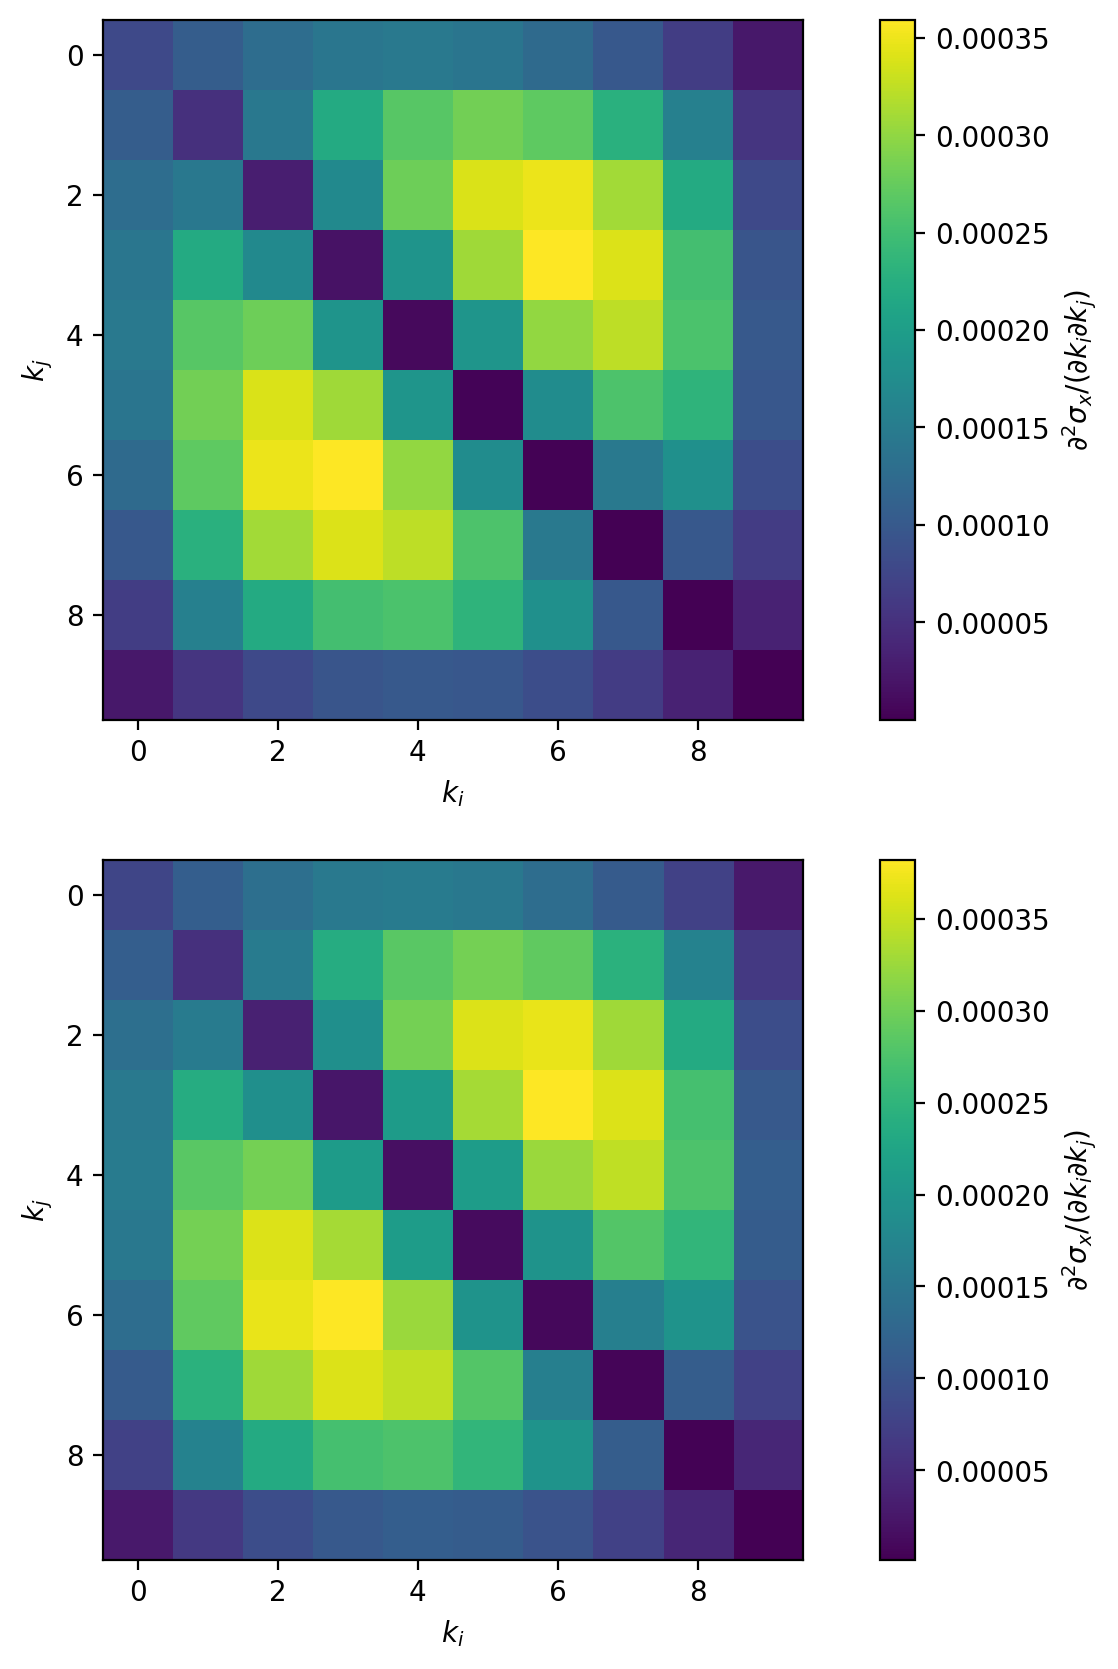

In [14]:
fig, axs = plt.subplots(2, figsize=(10,10))
cm = axs[0].imshow(hes_ad.detach().numpy())
axs[0].set_xlabel(r'$k_i$')
axs[0].set_ylabel(r'$k_j$')
fig.colorbar(cm,ax=axs[0], label=r'$\partial^2 \sigma_x / (\partial k_i \partial k_j)$')
cm = axs[1].imshow(hes_nd)
axs[1].set_xlabel(r'$k_i$')
axs[1].set_ylabel(r'$k_j$')
fig.colorbar(cm,ax=axs[1], label=r'$\partial^2 \sigma_x / (\partial k_i \partial k_j)$')

In [ ]:
# calculate gradient of beamsize with respect to quadrupole strengths:

# fixed parameters:
half_drift = Drift(L=0.9/2) # half drift
L_q = 0.1 # quad length

def beamsize(beam_in, quad_strengths):
    """Function of beamsize with respect to quad strengths"""
    # create lattice of len(quad_strengths) quadrupoles separated by drifts:
    lattice = [] # initialize lattice
    for k1 in quad_strengths:
        lattice.append( half_drift )
        lattice.append( Quadrupole(L=L_q, K1=k1) )
        lattice.append( half_drift )
        
    beam_out = track_lattice(beam_in, lattice)
    return beam_out.x.std()

beamsize_torch = lambda k1s: beamsize(beam_torch, k1s)
beamsize_np = lambda k1s: beamsize(beam_np, k1s)

In [22]:
n_quadrupoles = np.linspace(1, 10, 10, dtype=int)
n_quadrupoles

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [23]:
from time import perf_counter

time_counter = perf_counter
t_ad = []
t_nd = []
for n_quads in n_quadrupoles:
    print(n_quads)
    
    beamsize_torch = lambda k1s: beamsize(beam_torch, k1s)
    p_out = None
    t_0= time_counter()
    hes_ad = ad.hessian(beamsize_torch, torch.zeros(n_quads))
    t_f = time_counter()
    t_ad.extend([t_f - t_0])
    

    beamsize_np = lambda k1s: beamsize(beam_np, k1s)
    
    p_out = None
    t_0 = time_counter()
    hes_nd = nd.Hessian(beamsize_np)(np.zeros(n_quads))
    t_f = time_counter()
    t_nd.extend([t_f - t_0])
    print(n_quads)
    

1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10


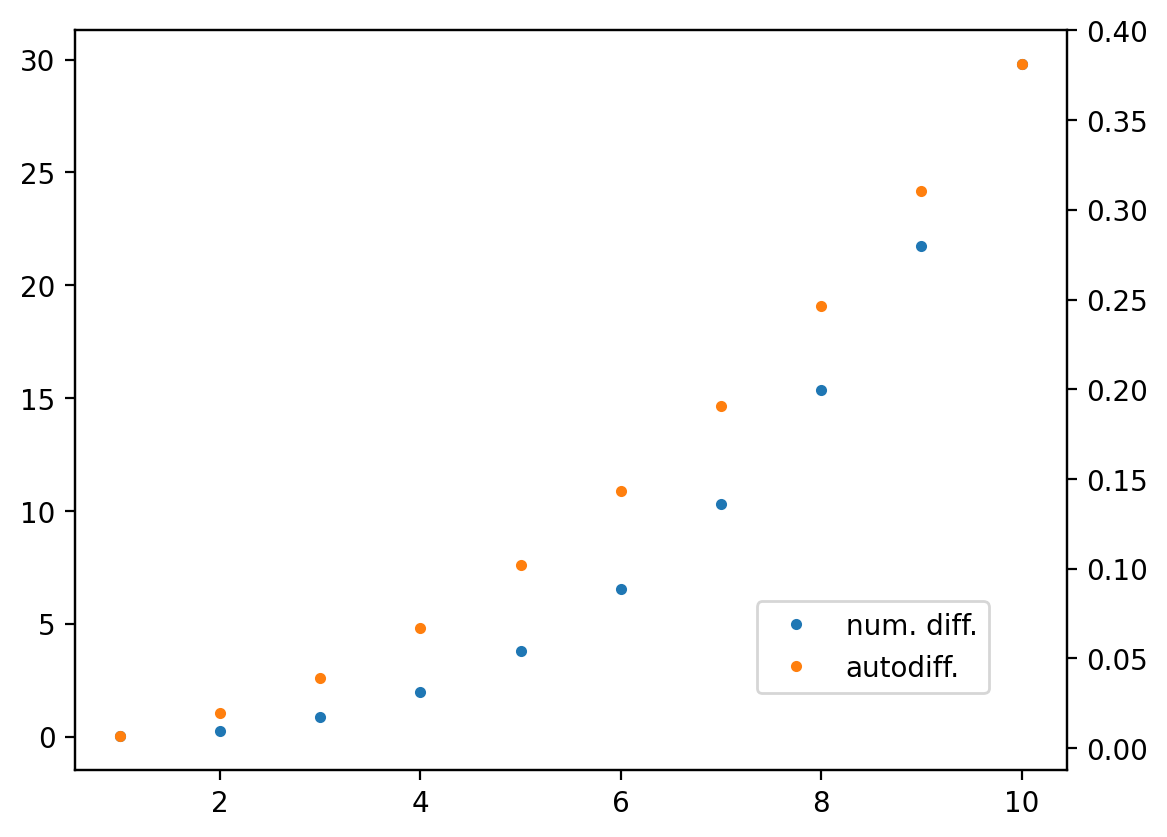

In [47]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(n_quadrupoles, t_nd, '.', color='C0', label='num. diff.')
ax2.plot(n_quadrupoles, t_ad, '.', color='C1', label='autodiff.')
fig.legend( bbox_to_anchor=(0.85, 0.3))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


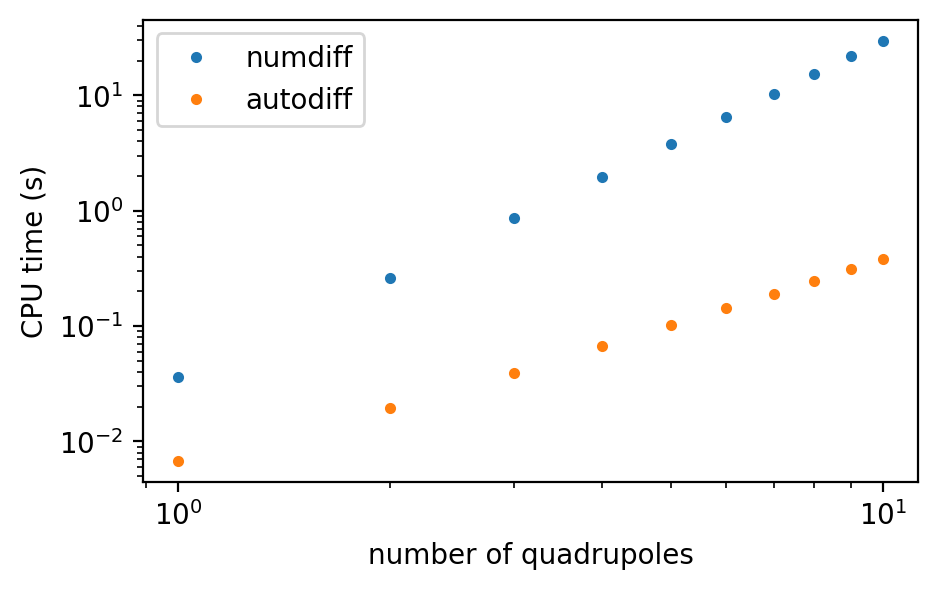

In [66]:
fig, ax = plt.subplots(figsize=(5,3))
ax.loglog(n_quadrupoles, t_nd, '.', color='C0', label='numdiff')
ax.loglog(n_quadrupoles, t_ad, '.', color='C1', label='autodiff')
plt.xlabel('number of quadrupoles')
plt.ylabel('CPU time (s)')
plt.legend()
plt.savefig('hessian-calc.png', bbox_inches='tight', dpi=600)
plt.savefig('hessian-calc.eps', bbox_inches='tight')